In [427]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

$$ d \sin{\theta} = m \lambda $$

$$ \frac{d y}{D} = m \lambda $$


In [438]:
#get the raw data
import pandas as pd
data = pd.read_csv('./data/ex_inv_data.csv', skiprows = 3, dtype = 'float')

#clean the data up a bit:

#Round the slit width to even multiples of 25 um
data.insert(2, "original d", data.d)
data.d = np.round(data.d / 25e-6) * 25e-6

#note this is actually wrong, it should be (grating to mirror dist) + sqrt(mirror to screen dist**2 + D_h**2)
data.insert(8, "D", np.sqrt(data.D_h **2 + data.D_v **2))

#convert y and delta_y to meters and divide it by n-1
data.y = data.y * 1e-3 / (data.n - 1)
data.delta_y = data.delta_y * 1e-3 / (data.n - 1)

data

,d_b,d_t,original d,d,delta_d,y,delta_y,n,D,D_h,D_v,delta_D_h
0,0.4974,0.4960,0.000497,0.000500,7.000000e-07,0.006500,0.000036,29,5.162857,5.16277,0.03,0.005
1,0.1954,0.1971,0.000196,0.000200,8.500000e-07,0.016200,0.000200,11,5.162857,5.16277,0.03,0.005
2,0.1015,0.0988,0.000100,0.000100,1.350000e-06,0.032167,0.000500,7,5.162857,5.16277,0.03,0.005
3,0.0509,0.0484,0.000050,0.000050,1.250000e-06,0.064500,0.002500,3,5.162857,5.16277,0.03,0.005
4,0.4974,0.4960,0.000497,0.000500,7.000000e-07,0.005882,0.000029,35,4.662867,4.66277,0.03,0.005
5,0.1954,0.1971,0.000196,0.000200,8.500000e-07,0.014667,0.000167,13,4.662867,4.66277,0.03,0.005
6,0.1015,0.0988,0.000100,0.000100,1.350000e-06,0.029167,0.000667,7,4.662867,4.66277,0.03,0.005
7,0.0509,0.0484,0.000050,0.000050,1.250000e-06,0.058000,0.002500,3,4.662867,4.66277,0.03,0.005
8,0.0234,0.0256,0.000024,0.000025,1.100000e-06,0.122000,0.017000,2,4.662867,4.66277,0.03,0.005
9,0.4974,0.4960,0.000497,0.000500,7.000000e-07,0.006176,0.000059,35,4.912862,4.91277,0.03,0.005


$$\frac{\Delta (\frac{1}{y})}{\frac{1}{y}} = \frac{\Delta y}{y}$$
$$\Delta y = \frac{\Delta y}{y^2}$$

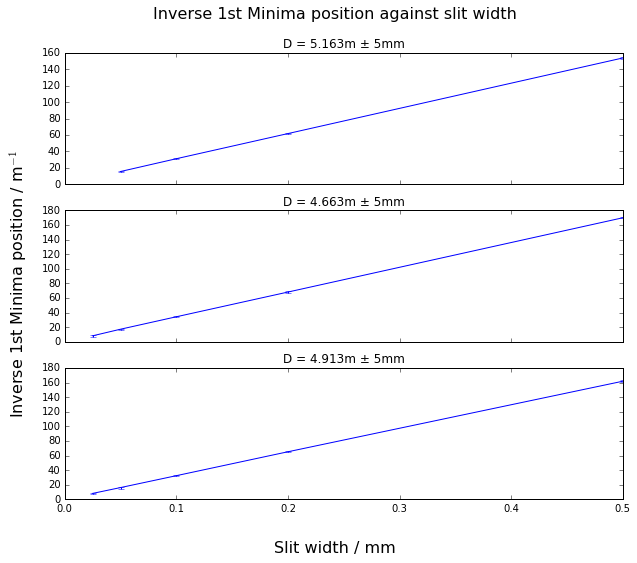

In [430]:
f, axes = plt.subplots(3, sharex='col')

# Set common labels
f.text(0.5, 0.04, 'Slit width / mm', ha='center', va='center', fontsize = 16)
f.text(0.06, 0.5, 'Inverse 1st Minima position / m$^{-1}$', ha='center', va='center', rotation='vertical', fontsize = 16)

f.suptitle("Inverse 1st Minima position against slit width", fontsize=16)

#loop over three subsets of the data and plot
for ex, ax in zip((data[0:4], data[4:9], data[9:]), axes):
    #ax.set_xlim([0, 5.0])
    
    #plotting inverse y
    inv_y = 1 / ex.y
    d_inv_y = ex.delta_y  / ex.y**2
    
    ax.errorbar(1e3 * ex["d"], inv_y, yerr = d_inv_y.as_matrix())
    ax.set_title("D = {:.4}m ± 5mm".format(ex.iloc[ 0,  11]))
    

We want to fit a function of the form:
$$ y = \lambda \frac{D}{d} $$

In [431]:
true_l = 632.8e-9

from scipy.optimize import curve_fit

def fn(x, l):
    D, d = x
    return l*D / d

def fit(D ,d ,y, delta_y, p0 = true_l):
    popt, pcov = curve_fit(fn, np.array([D, d]), y, p0 = p0, sigma = delta_y, absolute_sigma = True)
    l = popt[0]
    sigma = np.sqrt(pcov[0])[0]
    return l, sigma

l, delta_l = fit(data.D, data.d, data.y, data.delta_y)
print("Our lambda = {:.4} ± {:.1}".format(l, delta_l))


### results from the paper we found ###
g = 0.601 * 1e6 #m^-1
delta_g = 0.003 * 1e6 #m^-1
L = 2.653 #m
l2 = 1 / (g * L)
delta_l2 = delta_g / (L * g)**2

print("External lambda = {:.4} ± {:.1}".format(l2, delta_l2))

Our lambda = 6.289e-07 ± 2e-09
External lambda = 6.272e-07 ± 1e-09


The above regression doesn't take into account the errors in D so I'll try adding gaussian noise N(mean = 0, sigma) to the D values and runnning the regression many times, to estimate the error in the regression due to error in D

In [432]:
def trial():
    noise = np.random.normal(loc = 0.0, scale = 0.005, size = len(data.D))
    D = data.D + noise
    l, sigma = fit(D, data.d, data.y, data.delta_y)
    return l
ls = np.array([trial() for i in range(1000)])
print("sigma due to errors in D: ±{:.3}nm".format(ls.std() * 1e9))
print("sigma due to errors in y: ±{:.3}nm".format(delta_l * 1e9))
print("Total: ±{:.3}nm".format(np.sqrt(delta_l**2 + ls.std()**2) * 1e9))

sigma due to errors in D: ±0.294nm
sigma due to errors in y: ±1.84nm
Total: ±1.86nm


Clearly the error in D makes very little difference

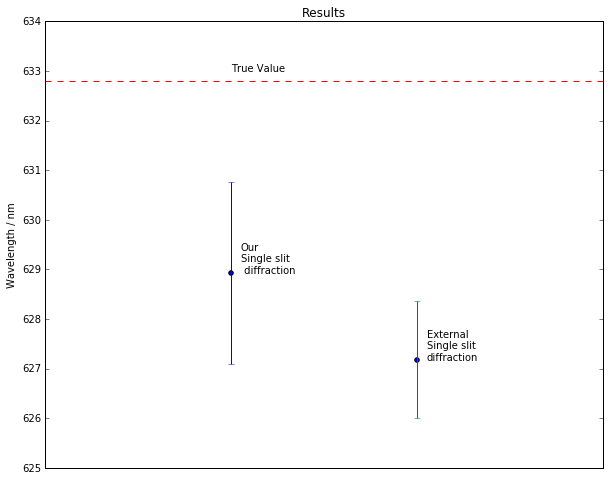

In [433]:
#collect the results together with some labels
ls = np.array([l, l2]) * 1e9
delta_ls = np.array([delta_l, delta_l2]) * 1e9
labels = ('Our\nSingle slit\n diffraction', 'External\nSingle slit\ndiffraction')

#our value for lambda
plt.scatter((1), (l * 1e9))
plt.errorbar((1), (l * 1e9), yerr = (delta_l * 1e9))
plt.annotate(labels[0], (1.05,l*1e9))

#external experiment
plt.scatter((2), (l2 * 1e9))
plt.errorbar((2), (l2 * 1e9), yerr = (delta_l2 * 1e9))
plt.annotate(labels[1], (2.05,l2*1e9))

#true value
plt.plot((0, 3), (true_l * 1e9, true_l * 1e9), "--")
plt.annotate("True Value", (1,true_l * 1e9 + 0.2))

plt.gca().get_xaxis().set_visible(False)
plt.title("Results")
plt.xlim((0,3))
plt.gca().set_ylabel('Wavelength / nm')